## Installing dependancies

In [1]:
from google.colab import drive
drive.mount('./data')

Mounted at ./data


In [2]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

In [3]:
%%shell
pip install torch_geometric==2.6.1
# pip install --no-index --find-links=/content/data/MyDrive/Research/wheels torch_scatter torch_sparse torch_cluster
pip install --no-index --find-links=/content/data/MyDrive/cudapip torch_scatter torch_sparse
pip install SciencePlots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00
Looking in links: /content/data/MyDrive/cudapip
Processing ./data/MyDrive/cudapip/torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl
Processing ./data/MyDrive/cudapip/torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl


In [4]:
import os
import numpy as np
import pandas as pd
import itertools
from matplotlib import pyplot as plt
import torch
from torch import Tensor, tensor, nn


import torch.nn.functional as F
import torch_geometric as pyg
from torch_scatter.composite import scatter_softmax
from torch_geometric.utils import scatter, negative_sampling
import pickle
import shutil
import scienceplots
import seaborn as sns
import gc
import matplotlib as mpl
import matplotlib.font_manager as fm


In [5]:
print(mpl.__version__)

plt.style.use(['science', 'notebook', 'grid'])
sns.set_style("whitegrid")

!wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
font_dirs = ["/content/"]
font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
for font_file in font_files:
    print(font_file) if 'TimesNewRoman' in font_file else None
    fm.fontManager.addfont(font_file)


plt.rcParams['font.serif'] = "Times New Roman"
plt.rcParams['font.family'] = "serif"

3.10.0
--2025-04-20 08:23:07--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-04-20 08:23:07--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘TimesNewRoman.ttf’

TimesNewRoman.ttf   100%[===================>] 814.89K  --.-KB/s    in 0.04s   

2025-04-20 08:23:07 (19.0 MB/s) - ‘TimesNewRoman.ttf’ saved [834452/834452]

/c

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.empty_cache()

## Configuration

In [8]:
class PathConfig:

  def __init__(self, drive_dataset_path, pickle_save_path):
    self.DRIVE_DATASET_PATH = drive_dataset_path
    self.PICKLE_SAVE_PATH = pickle_save_path
    if not os.path.exists(pickle_save_path):
      os.mkdir(pickle_save_path)

  DRIVE_DATASET_PATH = "/content/data/MyDrive/Research/dataset"
  PICKLE_SAVE_PATH = "/content/data/MyDrive/Research/dataset/parquets"

  paths = {

      #mappings
      'UID_MAP_PATH': 'uid_map.parquet',
      'ITEMID_MAP_PATH': './itemid_map.parquet',
      'RELATIONS_MAP_PATH': './relations_map.parquet',
      'TAGS_MAPPING_PATH': './tags_map.parquet',
      'BRANDS_MAPPING_PATH': './brands_map.parquet',
      'CATEGORY_MAPPING_PATH': './category_map.parquet',

      #triples
      'CATEGORY_HIERARCHY_PATH': './category_hierarchy.parquet',
      'USER_EMBEDDINGS_PATH': './userembeddings.parquet',
      'ITEM_EMBEDDIGNS_PATH': './itemembeddings.parquet',
      'TRIPLES_ITEMCAT_PATH': './triples_itemcat.parquet',
      'TRIPLES_BRANDS_PATH': './triples_brand.parquet',
      'TRIPLES_TAGS_PATH': './triples_tags.parquet',

      'INDEXER_DATA_PATH': './indexer_path.pickle',
      'TFIDF_MODEL_PATH': './tfidf.pickle'
  }

  @property
  def UID_MAP_PATH(self):
    return self.paths['UID_MAP_PATH']

  @property
  def ITEMID_MAP_PATH(self):
    return self.paths['ITEMID_MAP_PATH']

  @property
  def RELATIONS_MAP_PATH(self):
    return self.paths['RELATIONS_MAP_PATH']

  @property
  def TAGS_MAPPING_PATH(self):
    return self.paths['TAGS_MAPPING_PATH']

  @property
  def ITEMMETA_PARQUET_PATH(self):
    return self.paths['ITEMMETA_PARQUET_PATH']

  @property
  def REVIEW_PARQUET_PATH(self):
    return self.paths['REVIEW_PARQUET_PATH']

  @property
  def BRANDS_MAPPING_PATH(self):
    return self.paths['BRANDS_MAPPING_PATH']

  @property
  def CATEGORY_MAPPING_PATH(self):
    return self.paths['CATEGORY_MAPPING_PATH']

  @property
  def CATEGORY_HIERARCHY_PATH(self):
    return self.paths['CATEGORY_HIERARCHY_PATH']

  @property
  def USER_EMBEDDINGS_PATH(self):
    return self.paths['USER_EMBEDDINGS_PATH']

  @property
  def ITEM_EMBEDDIGNS_PATH(self):
    return self.paths['ITEM_EMBEDDIGNS_PATH']

  @property
  def TRIPLES_ITEMCAT_PATH(self):
    return self.paths['TRIPLES_ITEMCAT_PATH']

  @property
  def TRIPLES_BRANDS_PATH(self):
    return self.paths['TRIPLES_BRANDS_PATH']

  @property
  def TRIPLES_TAGS_PATH(self):
    return self.paths['TRIPLES_TAGS_PATH']

  @property
  def TFIDF_MODEL_PATH(self):
    return self.paths['TFIDF_MODEL_PATH']

  @property
  def INDEXER_DATA_PATH(self):
    return self.paths['INDEXER_DATA_PATH']

  # def copy_to_drive(self):
  #   self.use_local_paths()
  #   for path in self.paths:
  #     if os.path.exists(self.paths[path]):
  #       print('copy_to_drive: copying ', self.paths[path])
  #       shutil.copy(self.paths[path], os.path.join(self.DRIVE_DATASET_PATH, 'parquets'))

  def copy_to_local(self):
    self.use_drive_paths()
    for path in self.paths:
      if os.path.exists(self.paths[path]):
        shutil.copy(self.paths[path], './')
    self.use_local_paths()

  def use_drive_paths(self):
    for path in self.paths:
      self.paths[path] = os.path.join(self.DRIVE_DATASET_PATH, 'parquets', os.path.basename(self.paths[path]))

  def use_local_paths(self):
    for path in self.paths:
      self.paths[path] = './'+os.path.basename(self.paths[path])

In [9]:
class Config:
  paths = PathConfig("/content/data/MyDrive/Research/dataset", "/content/data/MyDrive/Research/dataset/parquets")

In [10]:
class Indexer:
  data = {}
  to_graph = {}
  from_graph = {}
  rel_types = {}
  reverse_rel_types = {}
  counter = 0
  config: Config = None

  def __init__(self, config):
    self.counter = 0
    self.config = config
    pass

  def clear(self):
    self.data = {}
    self.to_graph = {}
    self.from_graph = {}
    self.rel_types = {}
    self.reverse_rel_types = {}
    self.counter = 0

  def persist(self):
    pickler = IndexerPickler(self)
    pickler.persist(self.config.paths.INDEXER_DATA_PATH)

  @staticmethod
  def load(config):
    indexer = IndexerPickler.load(config.paths.INDEXER_DATA_PATH, config)
    return indexer


  def add_rel(self, id, reltype: str):
    self.rel_types[reltype] = id
    self.reverse_rel_types[id] = reltype


  def add_node(self, local_id, node_type):
    self.to_graph[local_id] = self.counter
    self.from_graph[self.counter] = local_id
    if node_type in self.data:
      self.data[node_type].add(self.counter)
    else:
      self.data[node_type] = {self.counter}
    self.counter += 1


  def add_nodes(self, local_ids, node_type:str):
    for a in range(len(local_ids)):
      self.to_graph[a] = self.counter
      self.from_graph[self.counter] = a
      if node_type in self.data:
        self.data[node_type].add(self.counter)
      else:
        self.data[node_type] = {self.counter}
      self.counter += 1

  def get_node_type_single_(self, graph_id) -> str:
    for key in self.data:
      if graph_id in self.data[key]:
        return key

  def reltype_to_index(self, reltypes: list | str) -> list | int:
    if isinstance(reltypes, str):
      return self.node_type[reltypes]
    else:
      index_list = []
      for a in reltypes:
        index_list.append(self.rel_types[a])
      return index_list


  def index_to_reltype(self, index: list | str) -> list | str:
    if isinstance(index, int):
      return self.reverse_rel_types[index]
    else:
      rel_list = []
      for a in index:
        rel_list.append(self.reverse_rel_types[a])
      return rel_list


  def node_type(self, graph_ids) -> str | list:
    if not isinstance(graph_ids, list):
      return self.get_node_type_single_(graph_ids)

    node_types = []
    for a in graph_ids:
      node_types.append(self.get_node_type_single_(a))
    return node_types


  def graph_idx(self, local_index: int | list):
    '''Give the graph index providex the local index'''
    if isinstance(local_index, list):
      indexes = []
      for a in local_index:
        indexes.append(self.to_graph[a])
      return indexes
    return self.to_graph[local_index]

  def local_idx(self, graph_Index: int|list):
    '''Give the local index prodvided graph index (or indexes)'''
    if isinstance(graph_Index, list):
      indexes = []
      for a in graph_Index:
        indexes.append(self.from_graph[a])
      return indexes
    return self.from_graph[graph_Index]



In [11]:
class IndexerPickler:
  data = {}
  to_graph = {}
  from_graph = {}
  rel_types = {}
  reverse_rel_types = {}
  counter = 0

  def __init__(self, index:Indexer):
    self.counter =  index.counter
    self.data =  index.data
    self.to_graph =  index.to_graph
    self.from_graph =  index.from_graph
    self.rel_types =  index.rel_types
    self.reverse_rel_types =  index.reverse_rel_types
    self.counter = index.counter

  def persist(self, path):
    with open(path, 'wb') as f:
      pickle.dump(self, f)

  @staticmethod
  def load(path, config):
    indexer = None
    with open(path, 'rb') as f:
      ctx = pickle.load(f)
      indexer = Indexer(config)
      indexer.counter = ctx.counter
      indexer.data = ctx.data
      indexer.to_graph = ctx.to_graph
      indexer.from_graph = ctx.from_graph
      indexer.rel_types = ctx.rel_types
      indexer.reverse_rel_types = ctx.reverse_rel_types
      return indexer

## R-GNN Network Implementation

Checkpoint class implements saving and restoring model and training process if needed in environment like colab, due to termination of runtimes. `CheckPoint` stores epoch, model state, optimizer state and last loss values.

In [12]:
class Checkpoint:

  def __init__(self, filename):
    self.filename = filename

  def save(self, model, optimizer, epoch, loss):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, self.filename)
    print(f"Checkpoint saved at epoch {epoch} at path {self.filename}")


  def load(self, model, optimizer):
    if not os.path.exists(self.filename):
      return (0, 0)
    checkpoint = torch.load(self.filename, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from {self.filename}. Checkpoint was saved at epoch {epoch}.")
    return epoch, loss

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# Global utilities for low level tasks

def gtensor(data, dtype=torch.float16, requires_grad: bool = False, pin_memory: bool = False) -> Tensor:
  '''Quick utility to pin memory and move to device. device has to in global scope'''
  global device
  return torch.tensor(data).to(device=device, dtype=dtype, requires_grad=requires_grad, pin_memory=pin_memory)



```
`# This is formatted as code`
```

## Graph loaders and Data Loader Utilities

From feature engineering, we have following files.

1. itemembeddings.parquet - Item embeddings (TF-IDF 32 dim)
1. itemid_map.parquet - Mapping file for items (id, asinOfItem) Items are identified by it's ASIN(*Amazon Standard Identification Number*)
1. relations_map.parquet - Mapping file for Relation types to ids
1. tags_map.parquet - Mapping files for Tag to it's ids
1. triples_brand.parquet - Item to brand node relations as triples file. (contains item id and brand id, relation type is implicit from relations map file)
1. triples_itemcat.parquet - Item to category relations as file.
1. triples_tags.parquet - Item to tags file
1. uid_map.parquet - User Id to Amazon user Id mapping
1. userembeddings.parquet - Purchase triples. This file describes user-item bi-partite graph. **Embeddings are on relations.**

File paths are handled by `PathConfig` class above.




In [15]:
class Dataset:
  df: pd.DataFrame = None

  def assign(self, df: pd.DataFrame):
    self.df = df

  def __repr__(self):
    return repr(self.df)

  def delete(self):
    self.df = None

class DataLoader:
  config: Config = None
  data = {
      'mapbrands': Dataset(),
      'mapcats': Dataset(),
      'mapitems': Dataset(),
      'mapusers': Dataset(),
      'maptags': Dataset(),
      'purchases': Dataset(),
      'emb_item': Dataset(),
      'rel_itembrands': Dataset(),
      'rel_itemcats': Dataset(),
      'rel_itemtags': Dataset(),
      'rel_catcats': Dataset(),
      'rel_usercats': Dataset()
  }

  def __init__(self, config):
    self.config = config

  def del_all(self):
    for key in self.data.keys():
      self.data[key].delete()

  def del_one(self, key):
    self.data[key].delete()

  def get_data_set(self, dataset_name, path, id_col=None) -> Dataset:
    ds = self.data[dataset_name]
    if ds.df is None:
      ds.assign(pd.read_parquet(path).drop_duplicates())
      print('dataset', dataset_name, ds.df.columns, 'id_col', id_col)
      if id_col:
        if id_col not in ds.df.columns:
          print('dataset', dataset_name, 'doesnt have', id_col, 'col as id_col')
          raise Exception()
        ds.df[id_col] = np.arange(len(ds.df[id_col]))
        print('dataset', dataset_name, 'has id ', len(ds.df.id))
    return ds

  def brands(self) -> pd.DataFrame:
    return self.get_data_set('mapbrands', self.config.paths.BRANDS_MAPPING_PATH).df

  def cats(self) -> pd.DataFrame:
    return self.get_data_set('mapcats', self.config.paths.CATEGORY_MAPPING_PATH).df

  def users(self) -> pd.DataFrame:
    return self.get_data_set('mapusers', self.config.paths.UID_MAP_PATH).df

  def tags(self) -> pd.DataFrame:
    return self.get_data_set('maptags', self.config.paths.TAGS_MAPPING_PATH).df

  def items(self) -> pd.DataFrame:
    return self.get_data_set('mapitems', self.config.paths.ITEMID_MAP_PATH).df

  def purchases(self) -> pd.DataFrame:
    return self.get_data_set('purchases', self.config.paths.USER_EMBEDDINGS_PATH).df

  def item_emb(self) -> pd.DataFrame:
    return self.get_data_set('emb_item', self.config.paths.ITEM_EMBEDDIGNS_PATH).df

  def item_brands(self) -> pd.DataFrame:
    return self.get_data_set('rel_itembrands', self.config.paths.TRIPLES_BRANDS_PATH).df

  def item_cats(self) -> pd.DataFrame:
    return self.get_data_set('rel_itemcats', self.config.paths.TRIPLES_ITEMCAT_PATH).df

  def item_tags(self) -> pd.DataFrame:
    return self.get_data_set('rel_itemtags', self.config.paths.TRIPLES_TAGS_PATH).df

  def cat_cats(self) -> pd.DataFrame:
    return self.get_data_set('rel_catcats', self.config.paths.CATEGORY_HIERARCHY_PATH).df

  def user_cats(self) -> pd.DataFrame:

    if self.data['rel_usercats'].df is None:
      itemcat_df = pd.read_parquet(config.paths.TRIPLES_ITEMCAT_PATH, columns=['asin', 'cat'])
      user_df = pd.read_parquet(config.paths.USER_EMBEDDINGS_PATH, columns=['uid', 'asin'])
      user_df.dropna(inplace=True)

      merged = pd.merge(
        left=user_df,
        right=itemcat_df,
        on='asin',
        how='inner'
      )
      merged.drop_duplicates(inplace=True)
      merged.drop(columns=['asin'], inplace=True)
      self.data['rel_usercats'].assign(merged)

    return self.data['rel_usercats'].df



In [16]:
# Node types
USER = 'user'
ITEM = 'item'
CATEGORY = 'cat'
BRAND = 'brand'
TAG = 'tag'

RELPURCHASE = (USER, 'purchase', ITEM)

In [17]:
class RelationTypes:

  types = {
   'purchase': 'purchase',
   'catcat': 'catcat',
   'catuser': 'catuser',
   'catitem': 'catitem',
   'itemtag': 'itemtag',
   'brand': 'brand',
  }

  def get_tuple(self, rel):
    if rel == 'purchase':
      return ('user', 'purchase', 'item')
    if rel == 'catcat':
      return ('cat', 'catcat', 'cat')
    if rel == 'catuser':
      return ('user', 'catuser', 'cat')
    if rel == 'catitem':
      return ('item', 'catitem', 'cat')
    if rel == 'itemtag':
      return ('item', 'itemtag', 'tag')
    if rel == 'brand':
      return ('item', 'brand', 'brand')

  @property
  def purchase(self):
    return 'purchase'

  @property
  def catcat(self):
    return 'catcat'  # category hierarchial relations

  @property
  def catuser(self):
    return 'catuser' # user-category

  @property
  def catitem(self):
    return 'catitem' # item-category

  @property
  def tag(self):
    return 'itemtag' # item-tag

  @property
  def brand(self):
    return 'brand'# item-brand




In [18]:
rel_tuples = {}

## Graph Neural Network based Recommendation

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_scatter.composite import scatter_softmax
from torch_geometric.utils import scatter

class RGNNLayer(nn.Module):
    def __init__(self, embedding_dim):
        super(RGNNLayer, self).__init__()

        self.attn = nn.Linear(embedding_dim, 1)
        self.time_decay = nn.Linear(1, 1)
        self.rating_scale_param = nn.Parameter(torch.tensor(1.0))
        self.rating_item_param = nn.Parameter(torch.tensor(1.0))

        nn.init.xavier_uniform_(self.attn.weight)
        nn.init.xavier_uniform_(self.time_decay.weight)

    def forward(self, h_dict, edge_index_dict, edge_attr_dict):
        # Fetch embeddings
        new_h_dict = {key: h.clone() for key, h in h_dict.items()}

        for edge_type, (src, dst) in edge_index_dict.items():
            if edge_type == ('user', 'purchase', 'item'):
                edge_feat = edge_attr_dict[edge_type]

                unique_users, inverse_indices = torch.unique(src, return_inverse=True)

                # Item attention
                attn_logits = self.attn(h_dict['item'][dst]).squeeze(-1)
                attn_logits = scatter_softmax(attn_logits, src, dim=0)

                # Time decay
                time_feat = edge_feat[:, 0]
                norm_time_feat = (time_feat - time_feat.min()) / (time_feat.max() - time_feat.min() + 1e-8)
                time_factor = torch.exp(-self.time_decay(norm_time_feat.unsqueeze(-1)))

                edge_weight = attn_logits.unsqueeze(-1) * time_factor
                agg = scatter(edge_weight * h_dict['item'][dst], inverse_indices, dim=0, reduce='mean')

                new_h_dict['user'][unique_users] += agg

                # User to item attention
                attn_logits = self.rating_item_param * edge_feat[:, 5]
                attn_score = scatter_softmax(attn_logits, dst, dim=0)
                edge_weight = attn_score.unsqueeze(-1)

                agg = scatter(edge_weight * h_dict['user'][src], dst, dim=0, reduce='mean', dim_size=h_dict['item'].shape[0])
                new_h_dict['item'] += agg

            elif edge_type == ('item', 'catitem', 'cat'):
                agg = scatter(h_dict['cat'][dst], src, dim=0, reduce='mean', dim_size=h_dict['item'].shape[0])
                new_h_dict['item'] += agg
                agg = scatter(h_dict['item'][src], dst, dim=0, reduce='mean', dim_size=h_dict['cat'].shape[0])
                new_h_dict['cat'] += agg

            elif edge_type == ('item', 'brand', 'brand'):
                agg = scatter(h_dict['brand'][dst], src, dim=0, reduce='mean', dim_size=h_dict['item'].shape[0])
                new_h_dict['item'] += agg
                agg = scatter(h_dict['item'][src], dst, dim=0, reduce='mean', dim_size=h_dict['brand'].shape[0])
                new_h_dict['brand'] += agg

            elif edge_type == ('user', 'catuser', 'cat'):
                agg = scatter(h_dict['cat'][dst], src, dim=0, reduce='mean', dim_size=h_dict['user'].shape[0])
                new_h_dict['user'] += agg
                agg = scatter(h_dict['user'][src], dst, dim=0, reduce='mean', dim_size=h_dict['cat'].shape[0])
                new_h_dict['cat'] += agg

        for key in new_h_dict:
            new_h_dict[key] = F.normalize(new_h_dict[key], dim=1)

        return new_h_dict

class RGNN(nn.Module):

  def __init__(self, num_nodes_dict, embedding_dim, num_layers):
    super(RGNN, self).__init__()

    self.embeddings = nn.ModuleDict({
        node_type: nn.Embedding(num_nodes, embedding_dim)
        for node_type, num_nodes in num_nodes_dict.items()
    })

    self.layers = nn.ModuleList([
      RGNNLayer(embedding_dim) for _ in range(num_layers)
    ])

  def forward(self, edge_index_dict, edge_attr_dict):
    h_dict = {node: self.embeddings[node].weight for node in self.embeddings}
    for layer in self.layers:
        h_dict = layer(h_dict, edge_index_dict, edge_attr_dict)
    return h_dict


In [20]:
import torch
import torch.nn as nn
import torch_geometric as pyg

class LinkPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super().__init__()
        self.mlp = pyg.nn.MLP([in_dim * 2, hidden_dim, 1], act='relu')  # MLP for scoring
        self.init_weights()  # Call weight initialization

    def init_weights(self):
        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Apply Xavier init
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # Set bias to zero

    def forward(self, user_emb, item_emb):
        x = torch.cat([user_emb, item_emb], dim=-1)  # Concatenate embeddings
        return torch.sigmoid(self.mlp(x)).squeeze(-1)  # Output score in [0,1]


In [21]:
import torch
import torch.nn as nn

class DotProductLinkPredictor(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, user_emb, item_emb):
        # Compute dot product between user and item embeddings
        return (user_emb * item_emb).sum(dim=-1)

In [22]:
class TransR(nn.Module):
    def __init__(self, num_entities, num_relations, entity_dim, relation_dim):
        super(TransR, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, entity_dim)
        self.relation_embeddings = nn.Embedding(num_relations, relation_dim)
        self.projection_matrices = nn.Embedding(num_relations, entity_dim * relation_dim)

        nn.init.xavier_uniform_(self.entity_embeddings.weight)
        nn.init.xavier_uniform_(self.relation_embeddings.weight)
        nn.init.xavier_uniform_(self.projection_matrices.weight)

    def forward(self, head, relation, tail):
        h = self.entity_embeddings(head)
        r = self.relation_embeddings(relation)
        t = self.entity_embeddings(tail)
        M_r = self.projection_matrices(relation).view(-1, entity_dim, relation_dim)

        h_proj = torch.bmm(h.unsqueeze(1), M_r).squeeze(1)
        t_proj = torch.bmm(t.unsqueeze(1), M_r).squeeze(1)
        return torch.norm(h_proj + r - t_proj, p=2, dim=-1)

In [23]:
rel_types = RelationTypes()

In [24]:
config = Config()
rel_types = RelationTypes()
#indexer = Indexer(config)
#index_pickler = IndexerPickler(indexer)
data_loader = DataLoader(config)
checkpoint_saver = Checkpoint(os.path.join(config.paths.PICKLE_SAVE_PATH, 'checkpoint.pt'))

In [25]:
# Load parquets and pickles from drive
config.paths.copy_to_local()

In [26]:
from torch_geometric.data import HeteroData
from torch_geometric.loader import NeighborLoader
from torch_geometric.transforms import ToUndirected

In [27]:
def load_node_ids():
  # indexer.clear()

  #load maps
  uid_df = pd.read_parquet(config.paths.UID_MAP_PATH, columns=['id'])
  itemid_df = pd.read_parquet(config.paths.ITEMID_MAP_PATH, columns=['id'])
  catid_df = pd.read_parquet(config.paths.CATEGORY_MAPPING_PATH, columns=['id'])
  brandid_df = pd.read_parquet(config.paths.BRANDS_MAPPING_PATH, columns=['id'])
  tags_df = pd.read_parquet(config.paths.TAGS_MAPPING_PATH, columns=['id'])

  node_counts = {
      USER: len(uid_df),
      ITEM: len(itemid_df),
      CATEGORY: len(catid_df),
      BRAND: len(brandid_df),
      TAG: len(tags_df)
  }

  del uid_df
  del itemid_df
  del catid_df
  del brandid_df
  del tags_df
  return node_counts

node_counts = load_node_ids()

In [ ]:
node_counts

{'user': 157212, 'item': 589356, 'cat': 79, 'brand': 43217, 'tag': 188525}

## Knowledge Graph Construction

In [28]:
data = HeteroData()

In [29]:
from re import I
class KGBuilder:

  data:HeteroData
  dl:DataLoader = None

  def __init__(self, data: HeteroData, data_loader):
    self.data = data
    data[USER].num_nodes = node_counts[USER]
    data[ITEM].num_nodes = node_counts[ITEM]
    data[CATEGORY].num_nodes = node_counts[CATEGORY]
    data[BRAND].num_nodes = node_counts[BRAND]
    self.dl = data_loader
    self.dl.del_all()


  def add_item_embeddings(self):
    item_df = self.dl.item_emb()
    self.data[ITEM].x = torch.tensor(item_df.iloc[:, 1:].values, dtype=torch.float) # First col is asin. So 1:.


  def add_purchase_embeddings(self):
    purchase_df = self.dl.purchases()
    purchase_df.dropna(inplace=True)
    user_ids = purchase_df['uid'].values.astype(np.int32)
    item_ids = purchase_df['asin'].values.astype(np.int32)
    ar = np.array([user_ids, item_ids])

    # # Check for overflow in user_ids
    # for user_id in user_ids:
    #     if user_id > np.iinfo(np.int32).max or user_id < np.iinfo(np.int32).min:
    #         print("Overflow in userid:", user_id)
    #         break

    # # Check for overflow in item_ids
    # for item_id in item_ids:
    #     if item_id > np.iinfo(np.int32).max or item_id < np.iinfo(np.int32).min:
    #         print("Overflow in itemid:", item_id)
    #         break

    embedding_column_filter = ['unixReviewTime', 'sin_day', 'cos_day', 'sin_month', 'cos_month', 'rating']
    self.data[USER, rel_types.purchase, ITEM].edge_index = torch.tensor(ar, dtype=torch.int64)
    self.data[USER, rel_types.purchase, ITEM].edge_attr = torch.tensor(purchase_df[embedding_column_filter].values, dtype=torch.float)
    print('X>>>>', len(user_ids), len(purchase_df[embedding_column_filter]))

  def add_brand_edges(self):
    brand_df = self.dl.item_brands()
    item_ids = brand_df.asin.values.astype(int)
    brand_ids = brand_df.brand.values.astype(int)
    ar = np.array([item_ids, brand_ids])
    self.data[ITEM, rel_types.brand, BRAND].edge_index = torch.tensor(ar, dtype=torch.int64)


  def add_category_edges(self):
    cat_df = self.dl.item_cats()
    item_ids = cat_df.asin.values
    cat_ids = cat_df.cat.values
    ar = np.array([item_ids, cat_ids])
    self.data[ITEM, rel_types.catitem, CATEGORY].edge_index = torch.tensor(ar, dtype=torch.int64)

  def add_user_categories(self):
    merged = self.dl.user_cats()
    user_ids = merged['uid'].values.astype(np.int32)
    cat_ids = merged['cat'].values.astype(np.int32)
    ar = np.array([user_ids, cat_ids])

    self.data[USER, rel_types.catuser, CATEGORY].edge_index = torch.tensor(ar, dtype=torch.int64)
    # $cat_df = pd.read_parquet(config.paths., columns=['uid', 'cat'])


In [30]:
data = HeteroData()
kg = KGBuilder(data, data_loader)
kg.add_item_embeddings()
kg.add_brand_edges()
kg.add_category_edges()
kg.add_purchase_embeddings()
kg.add_user_categories()

dataset emb_item Index(['asin', 'tf_0', 'tf_1', 'tf_2', 'tf_3', 'tf_4', 'tf_5', 'tf_6', 'tf_7',
       'tf_8', 'tf_9', 'tf_10', 'tf_11', 'tf_12', 'tf_13', 'tf_14', 'tf_15',
       'tf_16', 'tf_17', 'tf_18', 'tf_19', 'tf_20', 'tf_21', 'tf_22', 'tf_23',
       'tf_24', 'tf_25', 'tf_26', 'tf_27', 'tf_28', 'tf_29', 'tf_30', 'tf_31'],
      dtype='object') id_col None
dataset rel_itembrands Index(['asin', 'brand'], dtype='object') id_col None
dataset rel_itemcats Index(['asin', 'cat'], dtype='object') id_col None
dataset purchases Index(['uid', 'asin', 'unixReviewTime', 'sin_day', 'cos_day', 'sin_month',
       'cos_month', 'rating'],
      dtype='object') id_col None
X>>>> 1122844 1122844


In [31]:
def sample_negative_edges(data, edge_type):
    """ Sample negative edges that do not exist in the graph. """
    pos_edge_index = data[edge_type].edge_index  # Existing edges
    num_neg_samples = pos_edge_index.size(1)  # Sample same number as positive edges

    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=(data['user'].num_nodes, data['item'].num_nodes),
        num_neg_samples=num_neg_samples,
        method="sparse"  # Optimized for large graphs
    )

    # Ensure negatives are truly missing
    existing_edges = set(map(tuple, pos_edge_index.T.tolist()))
    filtered_neg_edges = torch.stack([
        edge for edge in neg_edge_index.T if tuple(edge.tolist()) not in existing_edges
    ], dim=1)

    return filtered_neg_edges

In [32]:
neg_edges = sample_negative_edges(data, rel_types.get_tuple(rel_types.purchase))

In [33]:
data

HeteroData(
  user={ num_nodes=157212 },
  item={
    num_nodes=589356,
    x=[589356, 32],
  },
  cat={ num_nodes=79 },
  brand={ num_nodes=43217 },
  (item, brand, brand)={ edge_index=[2, 589356] },
  (item, catitem, cat)={ edge_index=[2, 589356] },
  (user, purchase, item)={
    edge_index=[2, 1122844],
    edge_attr=[1122844, 6],
  },
  (user, catuser, cat)={ edge_index=[2, 1120651] }
)

## Split dataset into train, validation and test

In [34]:
r = data_loader.purchases()

In [35]:
import pandas as pd
import numpy as np

def split_df(df, train_ratio=0.7, val_ratio=0.1):

    # Sort DataFrame by timestamp
    df = df.sort_values(by='unixReviewTime')

    # Compute split indices
    num_edges = len(df)
    train_idx = int(num_edges * train_ratio)
    val_idx = int(num_edges * (train_ratio + val_ratio))

    # Split data
    train_df = df.iloc[:train_idx]
    val_df = df.iloc[train_idx:val_idx]
    test_df = df.iloc[val_idx:]

    # Ensure all nodes exist in train
    train_users = set(train_df['uid'])
    train_items = set(train_df['asin'])

    val_df = val_df[val_df['uid'].isin(train_users) & val_df['asin'].isin(train_items)]
    test_df = test_df[test_df['uid'].isin(train_users) & test_df['asin'].isin(train_items)]

    return train_df, val_df, test_df

def create_train_heterograph(data, train_df, edge_type):

    train_graph = data.clone()  # Clone original graph

    # Convert train_df into edge_index format
    train_edges = torch.tensor(train_df[['uid', 'asin']].values, dtype=torch.long).T  # Shape: (2, num_edges)

    # Replace edge_index for the given relation
    train_graph[edge_type].edge_index = train_edges
    train_graph[edge_type].edge_attr = torch.from_numpy(train_df[['unixReviewTime', 'sin_day', 'cos_day', 'sin_month', 'cos_month', 'rating']].values).to(torch.float)
    return train_graph

def create_subset_heterograph(data, subset_df, train_df, edge_type, add_train_edges=True):

    subset_graph = data.clone()

    # Convert subset_df into edge_index format and edge_attr
    subset_edges = torch.tensor(subset_df[['uid', 'asin']].values, dtype=torch.long).T
    subset_attr = torch.tensor(subset_df[['unixReviewTime', 'sin_day', 'cos_day', 'sin_month', 'cos_month', 'rating']].values, dtype=torch.float)

    if add_train_edges:
        # Convert train_df into edge_index format and edge_attr
        train_edges = torch.tensor(train_df[['uid', 'asin']].values, dtype=torch.long).T
        train_attr = torch.tensor(train_df[['unixReviewTime', 'sin_day', 'cos_day', 'sin_month', 'cos_month', 'rating']].values, dtype=torch.float)

        # Combine edges and attributes
        all_edges = torch.cat([subset_edges, train_edges], dim=1)
        all_attrs = torch.cat([subset_attr, train_attr], dim=0)

        # Remove duplicate edges
        # unique_edges, indices = torch.unique(all_edges, dim=1, return_inverse=True)
        # unique_attrs = all_attrs[indices]
        unique_edges = all_edges
        unique_attrs = all_attrs
    else:
        unique_edges = subset_edges
        unique_attrs = subset_attr

    # Replace edge_index and edge_attr for the given relation
    subset_graph[edge_type].edge_index = unique_edges
    subset_graph[edge_type].edge_attr = unique_attrs

    return subset_graph



In [36]:
train_df, val_df, test_df = split_df(r, train_ratio=0.7, val_ratio=0.15)

In [37]:
train = create_train_heterograph(data, train_df, RELPURCHASE)

In [38]:
embedding_dim = 32

In [39]:
from torch_geometric.loader import LinkNeighborLoader

class Trainer:

  g: HeteroData
  model: torch.nn.Module
  optimizer: torch.optim.Optimizer
  criterion: torch.nn.Module
  device: torch.device
  neg_edges: torch.Tensor = None
  pos_edges: torch.Tensor = None
  prel = (USER, rel_types.purchase, ITEM)


  def __init__(self, train_graph, neg_edges, use_same_train:bool = False):
    if not use_same_train:
      self.g = train_graph.clone()
    else:
      self.g = train_graph
    #self.assign_edges_inital_emb_()
    self.neg_edges = neg_edges

  def assign_edges_inital_emb_(self):
    for node_type in self.g.node_types:
      if 'x' not in self.g[node_type]:
        num_nodes = self.g[node_type].num_nodes
        self.g[node_type].x = torch.empty(num_nodes, embedding_dim)  # Empty tensor
        torch.nn.init.xavier_uniform_(self.g[node_type].x)

  def assign_edges_inital_emb_any_(self, graph):
    for node_type in graph.node_types:
      if 'x' not in graph[node_type]:
        num_nodes = graph[node_type].num_nodes
        graph[node_type].x = torch.empty(num_nodes, embedding_dim)  # Empty tensor
        torch.nn.init.xavier_uniform_(graph[node_type].x)

  def fill_embeddings(self, edge_types, emb_size):
    for edge_type in self.g.edge_types:
      if edge_type in edge_types:
        edge_emb = self.g[edge_type].edge_attr
        pad_size = emb_size - edge_emb.shape[1]
        print(edge_emb.shape, pad_size)
        self.g[edge_type].edge_attr = torch.cat([edge_emb, torch.zeros(edge_emb.shape[0], pad_size)], dim=1)



  def add_negative_edges(self):
    '''For negative sampling'''
    n_nodes = self.g[USER].num_nodes + self.g[ITEM].num_nodes  # Total nodes
    purchases = self.g[self.prel]
    purchases_edges = purchases.edge_index
    print(purchases_edges.shape)
    n_purchase_edges = purchases_edges.shape[1]  # Existing purchases
    print('before negative sampling has ', n_purchase_edges, 'edges')
    filtered_neg = self.neg_edges[:, :n_purchase_edges]
    self.neg_edges = filtered_neg
    self.pos_edges = purchases_edges

    #adding zeros to edge_emb foor purchases
    purchase_nfeatures = purchases.edge_attr.shape[1]
    s = torch.cat([purchases.edge_attr, torch.zeros((n_purchase_edges, purchase_nfeatures), dtype=torch.float)], dim=0)


    print('neg: n_purchae_edge', n_purchase_edges, 'edge_attr:', s.shape)

    print('adding', filtered_neg.shape, ' negative edges')
    positiv_label = torch.ones(n_purchase_edges, dtype=torch.float)
    nagativ_label = torch.zeros(filtered_neg.shape[1], dtype=torch.float)

    # thses labels are used for supervised learning target and bce loss

    total_edges = torch.cat([purchases_edges, filtered_neg], dim=1)
    total_labels = torch.cat([positiv_label, nagativ_label], dim=0)
    print('total edges shape', total_edges.shape)
    purchases.edge_index = total_edges
    purchases.edge_label = total_labels
    purchases.edge_attr = s
    print(self.g[self.prel].edge_attr.shape)

  def evaluate2(self, model, link_pred, test_graph:HeteroData):
    self.assign_edges_inital_emb_any_(test_graph)
    test_graph.to(device)
    edge_index_dict = {key: test_graph[key].edge_index for key in test_graph.edge_types}
    edge_attr_dict = {key:  test_graph[key].edge_attr for key in  test_graph.edge_types if 'edge_attr' in train[key]}

    h_dict = model(test_graph.x_dict, test_graph.edge_index_dict)
    # print(list(h_dict.keys()))

    # Compute scores for positive and negative pairs
    user_emb = h_dict['user']
    item_emb = h_dict['item']

    pos_scores = link_pred(user_emb[edge_index_dict[self.prel][0]], item_emb[edge_index_dict[self.prel][1]])
    neg_scores = link_pred(user_emb[self.neg_edges[0]], item_emb[self.neg_edges[1]])

    return pos_scores, neg_scores  # Only output scores, no labels needed


  def evaluate(self, model, link_pred, test_graph:HeteroData):
    #self.assign_edges_inital_emb_any_(test_graph)
    test_graph.to(device)
    # x_dict = {node_type: test_graph[node_type].x for node_type in test_graph.node_types}
    edge_index_dict = {key: test_graph[key].edge_index for key in test_graph.edge_types}
    edge_attr_dict = {key:  test_graph[key].edge_attr for key in  test_graph.edge_types if 'edge_attr' in train[key]}

    h_dict = model(edge_index_dict, edge_attr_dict)

    # Step 2: Extract user and item embeddings
    user_emb = h_dict['user']
    item_emb = h_dict['item']

    # Step 3: Compute scores for positive and negative samples
    pos_scores = link_pred(user_emb[edge_index_dict[self.prel][0]], item_emb[edge_index_dict[self.prel][1]])
    neg_scores = link_pred(user_emb[self.neg_edges[0]], item_emb[self.neg_edges[1]])

    return pos_scores, neg_scores  # Only output scores, no labels needed



  def train(self, epoch, rgnn, link_pred):
    loss_graph = []

    print(self.g[self.prel].edge_attr.shape)

    self.g.to(device)

    edge_index_dict = {key: self.g[key].edge_index for key in self.g.edge_types}
    edge_attr_dict = {key:  self.g[key].edge_attr for key in  self.g.edge_types if 'edge_attr' in train[key]}

    print('s adfsd', edge_attr_dict[self.prel].shape)

    optimizer = torch.optim.Adam(itertools.chain(rgnn.parameters(),link_pred.parameters()),lr=0.01)


    # edge_label_index = data[('user', 'purchase', 'item')].edge_index.to(device)
    # edge_label = data[('user', 'purchase', 'item')].edge_attr.to(device)  # (Optional: ratings)
    # print("Full graph purchase edges:", self.g[('user', 'purchase', 'item')].edge_index.shape)

    # train_loader = LinkNeighborLoader(
    #     data=self.g,  # Your preprocessed HeteroData
    #     edge_label_index=(self.prel, self.g[self.prel].edge_index),  # Training edges
    #     num_neighbors={
    #         ('user', 'purchase', 'item'): [10, 10], # or some other value
    #         ('item', 'catitem', 'cat'):  [10, 10],  # or some other value
    #         ('item', 'brand', 'brand'): [10, 10],  # or some other value
    #         ('user', 'catuser', 'cat'):  [10, 10]
    #         # Add other edge types
    #     },
    #    # edge_label=self.g['user', 'purchases', 'item'].edge_label,  # Label (1 for pos, 0 for neg)
    #     batch_size=1024,  # Mini-batch size
    #     shuffle=True,  # Shuffle training data
    # )
    rgnn.train()
    link_pred.train()

    for epoch in range(epoch):
      i  = 0
      optimizer.zero_grad()

      # Step 1: Forward Pass in RGNN

      h_dict = rgnn(edge_index_dict, edge_attr_dict)  # Get updated embeddings
      # Step 2: Compute Scores for Positive and Negative Pairs
      user_emb = h_dict['user']
      item_emb = h_dict['item']

      pos_scores = link_pred(user_emb[self.pos_edges[0]], item_emb[self.pos_edges[1]])
      neg_scores = link_pred(user_emb[self.neg_edges[0]], item_emb[self.neg_edges[1]])

      pos_labels = torch.ones_like(pos_scores)
      neg_labels = torch.zeros_like(neg_scores)

      #------------------- remove NaN breaks GPU, nan - 0 ----------
      pos_scores = torch.nan_to_num(pos_scores, nan=0.5)
      neg_scores = torch.nan_to_num(neg_scores, nan=0.5)
      #-------------------------------------------------------

      print("Unique pos_labels:", torch.unique(pos_labels))
      print("Unique neg_labels:", torch.unique(neg_labels))
      if torch.isnan(pos_scores).any() or torch.isnan(neg_scores).any():
        print("NaN detected in scores!")

      if torch.isinf(pos_scores).any() or torch.isinf(neg_scores).any():
        print("Inf detected in scores!")

      if pos_scores.numel() > 0:
          print("pos_scores min:", pos_scores.min().item(), "max:", pos_scores.max().item())
      else:
          print("pos_scores is empty.")

      if neg_scores.numel() > 0:
          print("neg_scores min:", neg_scores.min().item(), "max:", neg_scores.max().item())
      else:
          print("neg_scores is empty.")


      # Step 3: Compute Loss (Binary Cross-Entropy)

      # loss = F.binary_cross_entropy(torch.cat([pos_scores, neg_scores]),
      #                             torch.cat([pos_labels, neg_labels]))

      scores = torch.cat([pos_scores, neg_scores])
      labels = torch.cat([pos_labels, neg_labels]).to(scores.device)

      # Step 4: Compute Loss using BCEWithLogitsLoss (no sigmoid needed)
      loss = F.binary_cross_entropy_with_logits(scores, labels)

      # Step 4: Backpropagation
      loss.backward()
      optimizer.step()
      print("Loss:", loss.item())
      loss_graph.append([epoch, loss.item()])


    return loss_graph

In [40]:
train2 = train.clone()
print(train2)
trainer = Trainer(train2, neg_edges, use_same_train=True)
trainer.fill_embeddings([(USER, rel_types.purchase, ITEM)], embedding_dim)
trainer.add_negative_edges()


HeteroData(
  user={ num_nodes=157212 },
  item={
    num_nodes=589356,
    x=[589356, 32],
  },
  cat={ num_nodes=79 },
  brand={ num_nodes=43217 },
  (item, brand, brand)={ edge_index=[2, 589356] },
  (item, catitem, cat)={ edge_index=[2, 589356] },
  (user, purchase, item)={
    edge_index=[2, 785990],
    edge_attr=[785990, 6],
  },
  (user, catuser, cat)={ edge_index=[2, 1120651] }
)
torch.Size([785990, 6]) 26
torch.Size([2, 785990])
before negative sampling has  785990 edges
neg: n_purchae_edge 785990 edge_attr: torch.Size([1571980, 32])
adding torch.Size([2, 785990])  negative edges
total edges shape torch.Size([2, 1571980])
torch.Size([1571980, 32])


In [41]:
data

HeteroData(
  user={ num_nodes=157212 },
  item={
    num_nodes=589356,
    x=[589356, 32],
  },
  cat={ num_nodes=79 },
  brand={ num_nodes=43217 },
  (item, brand, brand)={ edge_index=[2, 589356] },
  (item, catitem, cat)={ edge_index=[2, 589356] },
  (user, purchase, item)={
    edge_index=[2, 1122844],
    edge_attr=[1122844, 6],
  },
  (user, catuser, cat)={ edge_index=[2, 1120651] }
)

In [101]:
num_nodes_dict = {
  node_type: data[node_type].num_nodes
  for node_type in data.node_types
}
rgnn = RGNN(num_nodes_dict, 32, 3).to(device)
# link_pred = LinkPredictor(32,32).to(device)
link_pred = DotProductLinkPredictor().to(device)
loss = trainer.train(250, rgnn, link_pred)
torch.save(rgnn.state_dict(), '/content/data/MyDrive/Research/models/rgnn3.pth')
torch.save(link_pred.state_dict(), '/content/data/MyDrive/Research/models/link_pred3.pth')

torch.Size([1571980, 32])
s adfsd torch.Size([1571980, 32])
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: -0.5857609510421753 max: 0.9851975440979004
neg_scores min: -0.567684531211853 max: 0.9725884795188904
Loss: 0.7284037470817566
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: -0.5900166630744934 max: 0.9854313731193542
neg_scores min: -0.5766229629516602 max: 0.9723314642906189
Loss: 0.7249032855033875
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: -0.5933635234832764 max: 0.985689103603363
neg_scores min: -0.5828088521957397 max: 0.9722078442573547
Loss: 0.7214338779449463
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: -0.5956854820251465 max: 0.9859408736228943
neg_scores min: -0.5863817930221558 max: 0.972143709659

In [ ]:
test_df['uid'].value_counts().nlargest(100)

,count
uid,
6646,55
74264,25
1484,25
5695,22
3499,22
...,...
44529,11
18709,11
79697,11


In [111]:
validation_graph = create_subset_heterograph(data, val_df, train_df, RELPURCHASE, add_train_edges=False)
test_graph = create_subset_heterograph(data, test_df, train_df, RELPURCHASE, add_train_edges=False)

evaluater = Evaluator(trainer, test_graph, validation_graph)
test = evaluater.run_eval(rgnn, link_pred, test_df, 5)

torch.Size([589356, 32])
1484
user  1484 items [464570, 321939, 307580, 291649, 531058, 466749, 451935, 459208, 559870, 336472, 391732, 372213, 350655, 478101, 518800, 436789, 525624, 318275, 444802, 437839, 70924, 525320, 551478, 508583, 432299]
topk [326075, 140082, 531058, 355434, 459208]
1484 > hit count 2 precision 0.4 recall 0.08 f1 0.13333333333333333
1887
user  1887 items [417991, 311747, 481859, 508377, 553137, 2367, 376061, 425141, 298916, 418139, 300879, 418119]
topk [385877, 410791, 186291, 414797, 275180]
1887 > hit count 0 precision 0.0 recall 0.0 f1 0
3094
user  3094 items [470330, 343736, 181383, 4566, 168240, 143967, 148649, 204997, 172276, 406137, 181387, 481045, 446950]
topk [181383, 343736, 45132, 500514, 492763]
3094 > hit count 2 precision 0.4 recall 0.15384615384615385 f1 0.2222222222222222
3499
user  3499 items [230689, 453401, 193662, 461870, 375192, 391732, 427774, 371585, 237190, 240582, 511864, 148234, 406165, 5273, 377264, 366207, 427739, 417952, 280992, 26

In [109]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
from collections import OrderedDict


class Evaluator:
  trainer: Trainer = None
  test_graph: HeteroData = None
  validation_graph: HeteroData = None

  def __init__(self, trainer: Trainer, test_graph, validation_graph):
    self.trainer = trainer
    self.test_graph = test_graph
    self.validation_graph = validation_graph

  def eval_per_user(self, link_pred, test_df:pd.DataFrame, h_user, h_item, k):

    test_df = test_df.astype(int)
    top_100_uids = test_df['uid'].value_counts().nlargest(100).index
    useritem_dict = (
        test_df[test_df['uid'].isin(top_100_uids)]
        .groupby('uid')['asin']
        .apply(lambda x: list(OrderedDict.fromkeys(x)))
        .to_dict()
    )

    precisions, recalls, f1s = [], [], []
    xhitcount = 0
    i = 0
    mrrs = 0

    for user in useritem_dict:
      i += 1
      print(user)
      # if i > 10:
      #   return

      usr_emb = h_user[user].unsqueeze(0)
      usr_emb_exp = usr_emb.repeat(h_item.size(0), 1)
      scores = link_pred(usr_emb_exp, h_item).squeeze()
      #scores = link_pred(usr_emb.expand_as(h_item), h_item).squeeze()
      # print(usr_emb, scores)
      topk_items = torch.topk(scores, k=k).indices.cpu().tolist()

      hit_count = len(set(topk_items) & set(useritem_dict[user]))
      if hit_count > 0:
        xhitcount += 1
      precision = hit_count / k
      recall = hit_count / len(useritem_dict[user])
      f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
      print('user ', user, 'items', useritem_dict[user])
      print('topk', topk_items)
      print(user, '>', 'hit count', hit_count, 'precision', precision, 'recall', recall, 'f1', f1)
      x_mrr = self.reciprocal_rank(topk_items, useritem_dict[user])
      mrrs += x_mrr
      precisions.append(precision)
      recalls.append(recall)
      f1s.append(f1)

    print(f'mrr@{k}',mrrs, mrrs/len(useritem_dict))
    print(f'hitcount@{k}', xhitcount, xhitcount/len(useritem_dict))
    return np.mean(precisions), np.mean(recalls), np.mean(f1s)

  def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

  def compute_metrics(self, pos_scores, neg_scores):
    """
    Compute AUC and Average Precision (AP) for link prediction.
    """
    pos_scores = pos_scores.detach().cpu().numpy()
    neg_scores = neg_scores.detach().cpu().numpy()

    # Apply sigmoid to get probabilities
    pos_probs = self.sigmoid(pos_scores)
    neg_probs = self.sigmoid(neg_scores)

    # Labels: 1 for positive edges, 0 for negative edges
    y_true = np.concatenate([np.ones(len(pos_probs)), np.zeros(len(neg_probs))])
    y_scores = np.concatenate([pos_probs, neg_probs])

    # Compute AUC and Average Precision
    auc = roc_auc_score(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    return {'AUC': auc, 'AP': ap}

  def precision_at_k(self, pos_scores, neg_scores, k):
    """
    Compute Precision@K for link prediction.
    """
    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])

    # Sort scores in descending order
    sorted_indices = torch.argsort(scores, descending=True)
    top_k = labels[sorted_indices][:k]  # Take top-K labels

    precision = top_k.sum().item() / k
    return precision

  def reciprocal_rank(self, m, n):
    """
    m: list of recommended item IDs (sorted from most to least relevant)
    n: list of ground truth item IDs (e.g., items the user actually liked)
    Returns: reciprocal rank (float)
    """
    for i, item in enumerate(m):
        if item in n:
            return 1 / (i + 1)  # i is 0-based index
    return 0.0  # no relevant item found

  def compute_dgcc(self, pos_score, neg_score):
      # Get hardest negative (max score)
      hardest_neg = torch.max(neg_score, dim=0)[0]

      # Margin between pos and hardest neg
      margin = pos_score - hardest_neg  # should be > 0 ideally

      # Apply ReLU to focus only on correct predictions
      margin = torch.nn.functional.relu(margin)

      return margin.mean().item()


  def recall_at_k(self, pos_scores, neg_scores, k):
      """
      Compute Recall@K for link prediction.
      """
      scores = torch.cat([pos_scores, neg_scores])
      labels = torch.cat([torch.ones_like(pos_scores), torch.zeros_like(neg_scores)])

      # Sort scores in descending order
      sorted_indices = torch.argsort(scores, descending=True)
      top_k = labels[sorted_indices][:k]  # Take top-K labels

      recall = top_k.sum().item() / len(pos_scores)  # Normalize by number of actual positives
      return recall

  def f1_at_k(self, pos_scores, neg_scores, k):
    prec = self.precision_at_k(pos_scores, neg_scores, k)
    rec = self.recall_at_k(pos_scores, neg_scores, k)
    if prec + rec == 0:
        return 0
    return 2 * (prec * rec) / (prec + rec)

  def run_test(self, model, link_pred, is_undirected=False):
    if is_undirected:
      transform = ToUndirected()
      g = transform(self.test_graph)
      test_pos_scores, test_neg_scores = self.trainer.evaluate2(model, link_pred, g)
    else:
      test_pos_scores, test_neg_scores = self.trainer.evaluate(model, link_pred, self.test_graph)
    print("Test Metrics:", self.compute_metrics(test_pos_scores, test_neg_scores))

  def run_eval(self, model, link_pred, test_df, k, is_undirected=False):
    if is_undirected:
      transform = ToUndirected()
      g = transform(self.test_graph)
      test_pos_scores, test_neg_scores = self.trainer.evaluate2(model, link_pred, g)
      print("Test Metrics:", self.compute_metrics(test_pos_scores, test_neg_scores))
      print(f"Precision@{k}", self.precision_at_k(test_pos_scores, test_neg_scores, k))
      print(f"Recall@{k}", self.recall_at_k(test_pos_scores, test_neg_scores, k))
      print(f"MRR@{k}", self.compute_mrr(test_pos_scores, test_neg_scores))
      print(f"DGCC@{k}", self.compute_dgcc(test_pos_scores, test_neg_scores))

      return

    self.test_graph.to(device)
    edge_index_dict = {key: test_graph[key].edge_index for key in test_graph.edge_types}
    edge_attr_dict = {key:  test_graph[key].edge_attr for key in  test_graph.edge_types if 'edge_attr' in self.test_graph[key]}

    h_dict = model(edge_index_dict, edge_attr_dict)
    print(h_dict['item'].shape)
    p, r, f = self.eval_per_user(link_pred, test_df, h_dict['user'], h_dict['item'], k)

    print(f"Precision@{k}: {p:.4f}")
    print(f"Recall@{k}: {r:.4f}")
    print(f"F1@{k}: {f:.4f}")

    test_pos_scores, test_neg_scores = self.trainer.evaluate(model, link_pred, self.test_graph)
    print(self.compute_metrics(test_pos_scores, test_neg_scores))
    print(f"Precision@{k}", self.precision_at_k(test_pos_scores, test_neg_scores, k))
    print(f"Recall@{k}", self.recall_at_k(test_pos_scores, test_neg_scores, k))
    #print(f"MRR@{k}", self.compute_mrr(test_pos_scores, test_neg_scores))
    print(f"DGCC@{k}", self.compute_dgcc(test_pos_scores, test_neg_scores))

    return h_dict




In [ ]:
{k:test[k].shape for k in test}

{'user': torch.Size([157212, 32]),
 'item': torch.Size([589356, 32]),
 'cat': torch.Size([79, 32]),
 'brand': torch.Size([43217, 32])}

In [ ]:
test['user'][120932]

tensor([ 0.0975,  0.0927,  0.1033,  0.1397,  0.0678,  0.2432, -0.2066,  0.1292,
         0.0481,  0.1114,  0.2012, -0.0574, -0.0471, -0.2531, -0.2099,  0.0972,
        -0.0248,  0.2534, -0.3165,  0.3868,  0.0501,  0.0287, -0.4731,  0.0138,
         0.0079, -0.0215, -0.3137, -0.0304, -0.0415, -0.0124,  0.0006, -0.0808],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
test_graph[RELPURCHASE].edge_index

tensor([[ 99226, 142809, 126732,  ..., 129586,  41444,  34166],
        [458536, 471987, 431776,  ..., 557484, 565696, 557387]],
       device='cuda:0')

In [ ]:
test_df

,uid,asin,unixReviewTime,sin_day,cos_day,sin_month,cos_month,rating
841176,99226,458536.0,1483920000,0.968077,-0.250653,0.5,8.660254e-01,1.0
1113329,142809,471987.0,1483920000,0.968077,-0.250653,0.5,8.660254e-01,1.0
790296,126732,431776.0,1483920000,0.968077,-0.250653,0.5,8.660254e-01,0.0
745205,76554,411154.0,1483920000,0.968077,-0.250653,0.5,8.660254e-01,1.0
283848,106158,179680.0,1483920000,0.968077,-0.250653,0.5,8.660254e-01,1.0
...,...,...,...,...,...,...,...,...
1125964,122652,567278.0,1537920000,-0.848644,0.528964,-1.0,-1.836970e-16,1.0
1125155,152423,560855.0,1537920000,-0.848644,0.528964,-1.0,-1.836970e-16,1.0
1124742,129586,557484.0,1538006400,-0.724793,0.688967,-1.0,-1.836970e-16,0.0
1125789,41444,565696.0,1538006400,-0.724793,0.688967,-1.0,-1.836970e-16,1.0


In [ ]:
evaluater = Evaluator(trainer, train2, train2)
evaluater.run_eval(rgnn, link_pred, 10)

## Pure GCN and GraphSAGE

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv

class HeteroGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, metadata):
        super().__init__()
        self.convs = HeteroConv({
            edge_type: GCNConv(in_channels, hidden_channels, add_self_loops=False)
            for edge_type in metadata[1]
        }, aggr='sum')

        self.out_lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.convs(x_dict, edge_index_dict)
        for node_type in x_dict:
            x_dict[node_type] = F.relu(x_dict[node_type])

        return {k: self.out_lin(v) for k, v in x_dict.items()}  # Final node embeddings


In [ ]:
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import HeteroConv, GCNConv

class HeteroGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, metadata):
        super().__init__()
        print(metadata[1])
        self.convs = HeteroConv({
            edge_type: SAGEConv(in_channels, hidden_channels)
            for edge_type in metadata[1]  # Edge types
        }, aggr='mean')  # Aggregate neighbors using mean pooling
        print('rdx', self.convs)

        self.out_lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.convs(x_dict, edge_index_dict)
        for node_type in x_dict:
            x_dict[node_type] = F.relu(x_dict[node_type])

        return {k: self.out_lin(v) for k, v in x_dict.items()}  # Final node embeddings

In [ ]:
from torch_geometric.nn import HeteroConv, SAGEConv

class HeteroGraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, metadata):
        super(HeteroGraphSAGE, self).__init__()

        # First layer: HeteroConv
        self.convs_1 = HeteroConv({
            edge_type: SAGEConv(in_channels, hidden_channels)
            for edge_type in metadata[1]  # Edge types
        }, aggr='mean')

        # Output layer
        self.out_conv = HeteroConv({
            edge_type: SAGEConv(hidden_channels, out_channels)
            for edge_type in metadata[1]
        }, aggr='mean')

    def forward(self, x_dict, edge_index_dict):
        # First layer
        h_dict = self.convs_1(x_dict, edge_index_dict)

        # Output layer
        h_dict = self.out_conv(h_dict, edge_index_dict)

        return h_dict


In [ ]:
train2.metadata()[1]

In [ ]:
train['user'].num_nodes

In [ ]:

train2['user'].train_mask = torch.ones(train2['user'].num_nodes, dtype=torch.bool)
train_loader = NeighborLoader(
    data=train2,
    num_neighbors={key: [10, 10] for key in train2.edge_types},  # Sample 10 neighbors for 2 hops
    input_nodes=('user', train2['user'].train_mask),  # Specify training nodes
    batch_size=1024,
    shuffle=True,
)


hetero_model = HeteroGraphSAGE(32, 32, 32, train2.metadata()).to(device)
link_pred = LinkPredictor(32,32).to(device)

def train_gcn(num_epochs):
  minibatch_losses = []
  losses =[]
  model = hetero_model
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(num_epochs):
    minibatch_loss = []
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        h_dict = model(batch.x_dict, batch.edge_index_dict)
        print(list(h_dict.keys()))
        user_emb = h_dict['user']
        item_emb = h_dict['item']

        pos_scores = link_pred(user_emb[trainer.pos_edges[0]], item_emb[trainer.pos_edges[1]])
        neg_scores = link_pred(user_emb[trainer.neg_edges[0]], item_emb[trainer.neg_edges[1]])

        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)

        loss = F.binary_cross_entropy(torch.cat([pos_scores, neg_scores]), torch.cat([pos_labels, neg_labels]))
        loss.backward()
        optimizer.step()
        minibatch_loss.append(loss.item())
        print('mini-batch-loss', loss)

    minibatch_losses.append(minibatch_loss)
    losses.append([epoch, loss.item()])
    print(f"Epoch {epoch}, Loss: {loss.item()}")
  return losses, minibatch_losses

In [ ]:
train3
train2 = train3.clone()

In [ ]:
def assign_embs(g):
  for node_type in g.node_types:
    if 'x' not in g[node_type]:
      num_nodes = g[node_type].num_nodes
      g[node_type].x = torch.empty(num_nodes, embedding_dim)  # Empty tensor
      torch.nn.init.xavier_uniform_(g[node_type].x)

In [ ]:
transform = ToUndirected()
train2 = transform(train2)

In [ ]:
assign_embs(train2)

In [ ]:
#train2['user'].train_mask = torch.ones(train2['user'].num_nodes, dtype=torch.bool)

hetero_model = HeteroGraphSAGE(32, 32, 32, train2.metadata()).to(device)
#link_pred = LinkPredictor(32,32).to(device)
link_pred2 = DotProductLinkPredictor().to(device)
train2.to(device)

[('item', 'brand', 'brand'), ('item', 'catitem', 'cat'), ('user', 'purchase', 'item'), ('user', 'catuser', 'cat'), ('brand', 'rev_brand', 'item'), ('cat', 'rev_catitem', 'item'), ('item', 'rev_purchase', 'user'), ('cat', 'rev_catuser', 'user')]
rdx HeteroConv(num_relations=8)


HeteroData(
  user={
    num_nodes=157212,
    x=[157212, 32],
  },
  item={
    num_nodes=589356,
    x=[589356, 32],
  },
  cat={
    num_nodes=79,
    x=[79, 32],
  },
  brand={
    num_nodes=43217,
    x=[43217, 32],
  },
  (item, brand, brand)={ edge_index=[2, 589356] },
  (item, catitem, cat)={ edge_index=[2, 589356] },
  (user, purchase, item)={
    edge_index=[2, 1571980],
    edge_attr=[1571980, 32],
    edge_label=[1571980],
  },
  (user, catuser, cat)={ edge_index=[2, 1120651] },
  (brand, rev_brand, item)={ edge_index=[2, 589356] },
  (cat, rev_catitem, item)={ edge_index=[2, 589356] },
  (item, rev_purchase, user)={
    edge_index=[2, 1571980],
    edge_attr=[1571980, 32],
    edge_label=[1571980],
  },
  (cat, rev_catuser, user)={ edge_index=[2, 1120651] }
)

In [ ]:
def train_gcn(num_epochs):
  losses =[]
  model = hetero_model
  model.train()
  optimizer = torch.optim.Adam(itertools.chain(model.parameters(), link_pred.parameters()), lr=0.001)

  for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass for the full graph
    h_dict = model(train2.x_dict, train2.edge_index_dict)
    # print(list(h_dict.keys()))

    # Compute scores for positive and negative pairs
    user_emb = h_dict['user']
    item_emb = h_dict['item']

    pos_scores = link_pred(user_emb[trainer.pos_edges[0]], item_emb[trainer.pos_edges[1]])
    neg_scores = link_pred(user_emb[trainer.neg_edges[0]], item_emb[trainer.neg_edges[1]])

    pos_labels = torch.ones_like(pos_scores)
    neg_labels = torch.zeros_like(neg_scores)

    print("Unique pos_labels:", torch.unique(pos_labels))
    print("Unique neg_labels:", torch.unique(neg_labels))
    if torch.isnan(pos_scores).any() or torch.isnan(neg_scores).any():
      print("NaN detected in scores!")

    if torch.isinf(pos_scores).any() or torch.isinf(neg_scores).any():
      print("Inf detected in scores!")

    print("pos_scores min:", pos_scores.min().item(), "max:", pos_scores.max().item())
    print("neg_scores min:", neg_scores.min().item(), "max:", neg_scores.max().item())

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([pos_labels, neg_labels]).to(scores.device)

    # Step 4: Compute Loss using BCEWithLogitsLoss (no sigmoid needed)
    loss = F.binary_cross_entropy_with_logits(scores, labels)


    # Backpropagation
    loss.backward()
    optimizer.step()
    losses.append([epoch, loss.item()])
    print(f"Epoch {epoch}, Loss: {loss.item()}")
  return losses

In [ ]:
curve_data = train_gcn(100)

Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: 0.08423826098442078 max: 0.7851940393447876
neg_scores min: 0.0816924050450325 max: 0.7998901605606079
Epoch 0, Loss: 0.7139971256256104
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: 0.09290105849504471 max: 0.7642605900764465
neg_scores min: 0.10282489657402039 max: 0.7722097635269165
Epoch 1, Loss: 0.7131342887878418
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: 0.10236268490552902 max: 0.7425726056098938
neg_scores min: 0.10900244116783142 max: 0.7413628101348877
Epoch 2, Loss: 0.7123379707336426
Unique pos_labels: tensor([1.], device='cuda:0')
Unique neg_labels: tensor([0.], device='cuda:0')
pos_scores min: 0.1135648787021637 max: 0.7237458229064941
neg_scores min: 0.11500277370214462 max: 0.7240912318229675
Epoch 3, Loss: 0.71160310506

In [ ]:
hetero_model

In [ ]:
Evaluator(trainer, test_graph, validation_graph).run_eval(hetero_model, link_pred, 300, 100, is_undirected=True)

Test Metrics: {'AUC': np.float64(0.640029071425767), 'AP': np.float64(0.196600865029175)}
Precision@100 0.75
Recall@100 0.0008215036803364879


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [ ]:
Evaluator(trainer, test_graph, validation_graph).run_eval(hetero_model, link_pred, 300, is_undirected=True)

In [ ]:
Evaluator(trainer, test_graph, validation_graph).run_eval(hetero_model, link_pred, 300, is_undirected=True)

In [103]:
import matplotlib.pyplot as plt

def plot_training_curves(data):
    epochs, losses = zip(*data)

    plt.figure(figsize=(12, 5))

    plt.plot(epochs, losses, linestyle='-')
    plt.title('Training Loss for two layer RGNN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, 251, 10))

    plt.grid(True)

    plt.tight_layout()
    plt.show()


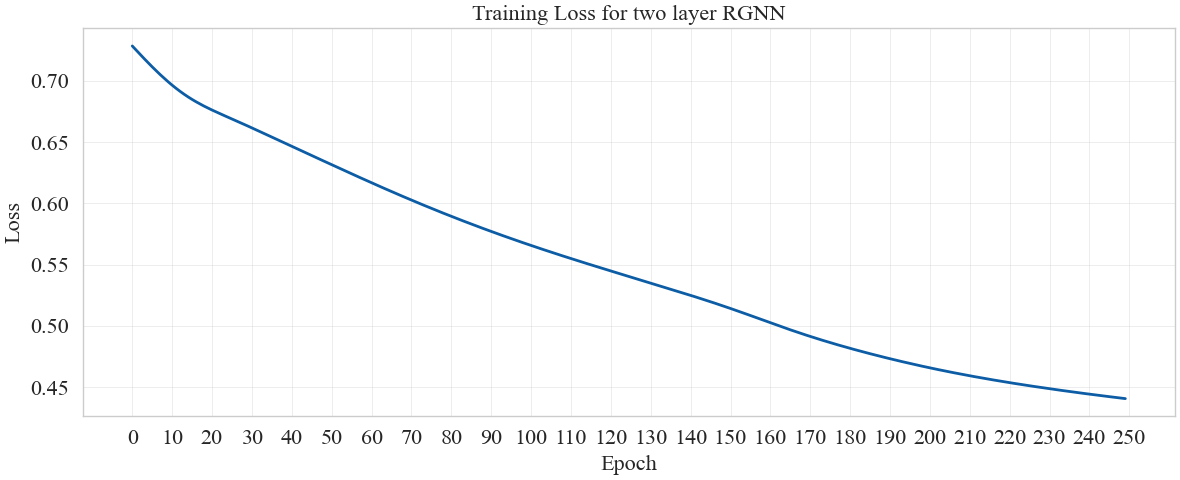

In [104]:
plot_training_curves(loss)

In [55]:
for a in rgnn.parameters():
  print(a)

Parameter containing:
tensor([[ 0.6324,  0.2602,  1.0060,  ..., -0.2370,  0.8319, -0.0168],
        [ 0.4263,  0.4605, -0.1064,  ..., -0.4313,  0.2537, -0.4882],
        [ 0.5200, -0.6116, -1.2294,  ..., -0.0023, -0.5451,  0.7924],
        ...,
        [ 1.7056,  1.4488, -0.1107,  ...,  1.9861, -0.4759,  0.2948],
        [-2.0637, -0.9448, -0.7876,  ...,  0.6960,  0.3269, -1.0256],
        [-0.4574, -0.8575,  0.4667,  ...,  0.1748,  0.1091,  0.3882]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 1.3806,  0.4017, -0.1486,  ...,  2.5337, -0.2337,  0.0749],
        [ 1.7791,  2.9892, -0.9751,  ...,  1.6041, -2.6883, -1.2987],
        [-0.7784,  2.7099,  0.2312,  ..., -0.8435, -1.3449,  0.0704],
        ...,
        [ 0.2624, -0.8391, -1.7412,  ...,  1.9040,  0.0070, -0.2260],
        [ 0.0076,  0.2616, -1.8436,  ...,  1.7029, -0.2870, -0.6093],
        [-1.3103,  1.5389,  0.4143,  ..., -0.6998,  1.1435, -0.4856]],
       device='cuda:0', requires_grad=True)


In [105]:

    edge_index_dict = {key: train2[key].edge_index for key in train2.edge_types}
    edge_attr_dict = {key:  train2[key].edge_attr for key in  train2.edge_types if 'edge_attr' in train[key]}


In [106]:
      h_dict = rgnn(edge_index_dict, edge_attr_dict)  # Get updated embeddings


In [107]:
# prompt: t-sne to visualize user embedding h_dict['user'] and item embedding h_dict['item']  in two plots

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(h_dict):
  """Visualizes user and item embeddings using t-SNE.

  Args:
    h_dict: A dictionary containing user and item embeddings.
  """
  cmap = plt.cm.get_cmap('tab10')
  # Perform t-SNE dimensionality reduction for users
  tsne_user = TSNE(n_components=2, random_state=42)
  user_embeddings_2d = tsne_user.fit_transform(h_dict['user'].detach().cpu().numpy()[:2000])

  # Perform t-SNE dimensionality reduction for items
  tsne_item = TSNE(n_components=2, random_state=42)
  item_embeddings_2d = tsne_item.fit_transform(h_dict['item'].detach().cpu().numpy()[:2000])


  # Plot user embeddings
  plt.figure(figsize=(8, 6))
  plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], cmap='viridis')
  plt.title('t-SNE Visualization of User Embeddings')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.show()

  # Plot item embeddings
  plt.figure(figsize=(8, 6))
  plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1],  cmap='viridis')
  plt.title('t-SNE Visualization of Item Embeddings')
  plt.xlabel('Dimension 1')
  plt.ylabel('Dimension 2')
  plt.show()

# Example usage (assuming 'h_dict' is available from your code)
# Replace with your actual h_dict
# visualize_embeddings(h_dict)


<ipython-input-107-1c7734938c90>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')
<ipython-input-107-1c7734938c90>:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(user_embeddings_2d[:, 0], user_embeddings_2d[:, 1], cmap='viridis')


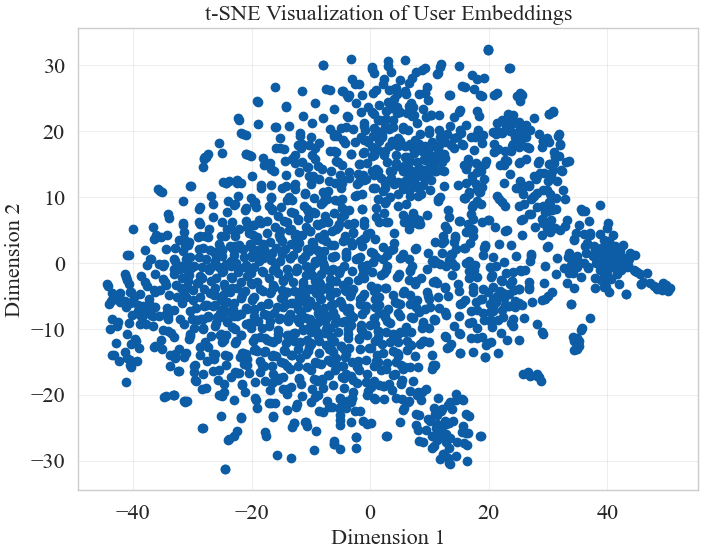

<ipython-input-107-1c7734938c90>:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1],  cmap='viridis')


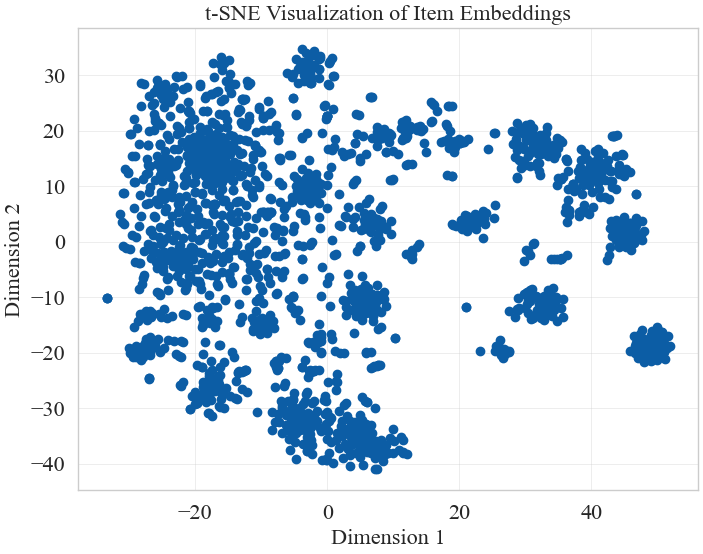

In [108]:
visualize_embeddings(h_dict)